## Introduction

This notebook is designed to train PrePR-CT and reproduce the results using the NeurIPS dataset. Before running the notebook, please ensure you have set the correct paths for the input and output files:

- **Data Path**: The location of the dataset files.
- **Results Path**: The directory where the output results will be saved.
- **Models Path**: The directory to save model checkpoints.
- **parent_dir**: The location of the cell type graphs

```python
data_path = "Cell-Type-Specific-Graphs/Data/"
save_path_results = "Cell-Type-Specific-Graphs/Results/"
save_path_models = "Cell-Type-Specific-Graphs/model_checkpoints/"
parent_dir = "Cell-Type-Specific-Graphs/graphs/"

In [1]:
import pandas as pd
import os
import scanpy as sc 
import sys
import numpy as np
import gzip
import matplotlib.pyplot as pl
from statistics import mode
from numpy.random import RandomState
import re
import seaborn as sns
from scipy.io import mmread
import pickle
from scipy.sparse import csr_matrix
from sklearn import preprocessing
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from sklearn.metrics.pairwise import euclidean_distances
from torch_geometric.utils import *
import tqdm.notebook as tq
import shutil
import sys 
sys.path.insert(0, '../')

import utils
from importlib import reload
reload(utils)
from utils import *

import model
from importlib import reload
reload(model)
from model import *
data_path = "Cell-Type-Specific-Graphs/Data/"
save_path_results = "Cell-Type-Specific-Graphs/Results/"
save_path_models = "Cell-Type-Specific-Graphs/model_checkpoints/"

2024-11-05 10:17:37.509353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2024-11-05 10:17:42.695884: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


## Import the Data

In [2]:
adata = sc.read(data_path+'Neurips_Data_Processed.h5ad')
adata.obs.rename({"sm_name": "condition"}, axis=1, inplace=True)
adata.obs['condition'] = adata.obs['condition'].replace('Dimethyl Sulfoxide', 'control')
adata = adata[adata.obs.condition != 'MLN 2238', :].copy()
crosstab_result = pd.crosstab(adata.obs['cell_type'], adata.obs['condition'])
display(crosstab_result)
adata

condition,Belinostat,Dabrafenib,Dactolisib,control,O-Demethylated Adapalene,Porcn Inhibitor III,R428
cell_type,,,,,,,
B cells,4167,3941,209,4399,255,282,220
Myeloid cells,2614,6143,87,5395,204,321,207
NK cells,3767,4962,299,5782,301,308,256
T cells CD4+,12152,9369,789,10778,599,880,598
T cells CD8+,1290,1281,55,1296,74,59,106
T regulatory cells,67,650,28,811,45,50,33


AnnData object with n_obs × n_vars = 85129 × 5000
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'condition', 'SMILES', 'dose_uM', 'timepoint_hr', 'control', 'cov_drug', 'condition_label', 'n_counts', 'SEACell'
    var: 'mt', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'condition_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [3]:
print(len(adata.obs.loc[adata.obs.condition == 'control']), len(adata.obs.loc[adata.obs.condition != 'control']))
print(len(adata.obs.loc[adata.obs.condition == 'control']) + len(adata.obs.loc[adata.obs.condition != 'control']))

28461 56668
85129


## Import the Cell Type Graphs in a Dictionary Form

In [4]:
cell_type_network = {}
# Leaf directory 
directory = "NeurIPS"
# Parent Directories 
parent_dir = "Cell-Type-Specific-Graphs/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in adata.obs.cell_type.unique():
    print(cell_type)
    cell_type_network[cell_type] = torch.load(os.path.join(path,cell_type+'_coexpr_graph.pkl'))
    if cell_type_network[cell_type].num_nodes >= max_nodes:
        max_nodes = cell_type_network[cell_type].num_nodes
print(max_nodes)
cell_type_network    

/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/NeurIPS
File exists!
T cells CD8+
T cells CD4+
NK cells
B cells
Myeloid cells
T regulatory cells
4744


{'T cells CD8+': Data(x=[4744, 5], edge_index=[2, 245256], edge_attr=[245256], pos=[4744]),
 'T cells CD4+': Data(x=[2835, 114], edge_index=[2, 245052], edge_attr=[245052], pos=[2835]),
 'NK cells': Data(x=[2925, 90], edge_index=[2, 245078], edge_attr=[245078], pos=[2925]),
 'B cells': Data(x=[2627, 70], edge_index=[2, 245128], edge_attr=[245128], pos=[2627]),
 'Myeloid cells': Data(x=[3268, 73], edge_index=[2, 245082], edge_attr=[245082], pos=[3268]),
 'T regulatory cells': Data(x=[3932, 27], edge_index=[2, 245262], edge_attr=[245262], pos=[3932])}

## Identify the testing drugs based on the E-distance from the control

In [5]:
testing_cell = 'B cells'
from scperturb import *
estats = edist(adata[adata.obs.cell_type == testing_cell].copy(), obs_key='condition', obsm_key='X_pca', dist='sqeuclidean')
testing_drug = estats.idxmax(axis = 1).loc['control']
print(testing_drug)
display(estats.loc['control'])
estats

100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

Dactolisib


condition
control                      0.000000
Belinostat                  36.631958
Dabrafenib                   1.994489
Porcn Inhibitor III          2.161041
O-Demethylated Adapalene     7.697643
Dactolisib                  57.793918
R428                        12.657523
Name: control, dtype: float64

condition,control,Belinostat,Dabrafenib,Porcn Inhibitor III,O-Demethylated Adapalene,Dactolisib,R428
condition,,,,,,,
control,0.000000,36.631958,1.994489,2.161041,7.697643,57.793918,12.657523
Belinostat,36.631958,0.000000,36.220913,43.551007,29.822833,44.417350,25.529321
Dabrafenib,1.994489,36.220913,0.000000,4.588553,12.629126,57.749970,13.337271
Porcn Inhibitor III,2.161041,43.551007,4.588553,0.000000,10.999436,61.941342,12.516960
O-Demethylated Adapalene,7.697643,29.822833,12.629126,10.999436,0.000000,34.700806,9.281204
Dactolisib,57.793918,44.417350,57.749970,61.941342,34.700806,0.000000,31.597727
R428,12.657523,25.529321,13.337271,12.516960,9.281204,31.597727,0.000000


## Compute DEGs per cell type and drug

In [6]:
adata.uns['gene_network'] = {}
adata.uns['rank_genes_groups_cov_DEGs'] = {}
for cell_type in adata.obs.cov_drug.unique():
    if (cell_type.split('_')[1] != 'control'):
        adata_cov = adata[(adata.obs.cov_drug == cell_type) | (adata.obs.cov_drug == cell_type.split('_')[0]+'_control'), 
        cell_type_network[cell_type.split('_')[0]].pos.tolist()].copy()
        sc.tl.rank_genes_groups(adata_cov, groupby = 'cov_drug',rankby_abs = True,
                                        reference = cell_type.split('_')[0]+'_control',n_genes = len(adata_cov.var))
        dedf = sc.get.rank_genes_groups_df(adata_cov, group=cell_type)
        dedf = dedf.loc[dedf['pvals_adj'] < 0.05].copy()
        DEGs_name = rank_genes(dedf)
        df = adata_cov.var.reset_index()
        adata.uns['gene_network'][cell_type] = cell_type_network[cell_type.split('_')[0]].pos.tolist()
        adata.uns['rank_genes_groups_cov_DEGs'][cell_type] = DEGs_name
        pd.DataFrame(DEGs_name).to_csv(save_path_results+"NeurIPS_"+cell_type+"_DEGs_name.csv")
        pd.DataFrame(adata_cov.var.index.values).to_csv(save_path_results+"NeurIPS_"+cell_type+"_all_genes.csv")

## Split the data 

In [7]:
testing_cell = 'B cells'
adata.obs["dose_value"] = 1.0
adata.obs['cov_drug'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)
label_encoder = preprocessing.LabelEncoder()
adata.obs["condition_label"] = label_encoder.fit_transform(adata.obs["condition"])
num_perts = adata.obs["condition_label"].max()+1
testing_drugs = ['Dactolisib', 'Belinostat']
valid_drugs = ['Belinostat', 'Dabrafenib']
adata.obs['split'] = 'train'
adata.obs.loc[(adata.obs.cell_type == testing_cell) & (adata.obs["condition"].isin(testing_drugs)), 'split'] = 'ood'
adata.obs.loc[(adata.obs.cell_type == 'Myeloid cells') & (adata.obs["condition"].isin(valid_drugs)), 'split'] = 'valid'
display(adata.obs.split.value_counts())

split
train    71996
valid     8757
ood       4376
Name: count, dtype: int64

## Match Control to Treatment Cells

In [8]:
stim_data = adata[adata.obs.condition != 'control'].copy()
stim_data.layers['ctrl_x'] = stim_data.X.A
ctrl_data = adata[adata.obs.condition == 'control'].copy()

for cell_type in adata.obs.cell_type.unique():
    genes = cell_type_network[cell_type].pos.tolist()
    cell_type_network[cell_type].x = torch.mean(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    std = torch.var(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    cell_type_network[cell_type].x = torch.cat([cell_type_network[cell_type].x.unsqueeze(1), std.unsqueeze(1)], dim = 1)    


for cov_drug in stim_data.obs.cov_drug.unique():
    cell_type = cov_drug.split('_')[0]
    ad_ctrl = ctrl_data[ctrl_data.obs.cell_type == cell_type].copy()
    ad_stim = stim_data[stim_data.obs.cov_drug == cov_drug].copy()
    num_samples = len(ad_stim)
    sele_samples = balance_subsample(np.array(ad_ctrl.obs.index.values.tolist()), np.array(ad_ctrl.obs.SEACell.values.tolist()), num_samples)
    stim_data[ ad_stim.obs.index.values,: ].layers['ctrl_x'] = ad_ctrl[sele_samples, :].copy().X.A

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsula

## Embed the compound structures using ChemBERTa

In [9]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
from tqdm import tqdm

chemberta = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

chemberta.eval()
def featurize_ChemBERTa(smiles_list, padding=True):
    embeddings_cls = torch.zeros(len(smiles_list), 600)
    embeddings_mean = torch.zeros(len(smiles_list), 600)

    with torch.no_grad():
        for i, smiles in enumerate(tqdm(smiles_list)):
            encoded_input = tokenizer(smiles, return_tensors="pt",padding=padding,truncation=True)
            model_output = chemberta(**encoded_input)
            
            embedding = model_output[0][::,0,::]
            embeddings_cls[i] = embedding
            
            embedding = torch.mean(model_output[0],1)
            embeddings_mean[i] = embedding
            
    return embeddings_cls.numpy(), embeddings_mean.numpy()

from rdkit import Chem

# Define a list of drugs and their corresponding SMILES strings
df_de = pd.read_parquet(data_path+"de_train.parquet")
drug_smiles = df_de[['sm_name', 'SMILES']].loc[df_de.sm_name.isin(adata.obs.condition.unique())]
drug_smiles = drug_smiles.drop_duplicates()
drug_smiles = dict(zip(drug_smiles['sm_name'], drug_smiles['SMILES']))
# Check if SMILES strings are canonical
canonical_smiles = {}
canonical_smiles_text = {}
for drug_name, smiles in drug_smiles.items():
    # Convert SMILES to RDKit molecule object
    print(drug_name, smiles)
    mol = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)
    print(mol)
    canonical_smiles_text[drug_name] = mol
    canonical_smiles[drug_name] = featurize_ChemBERTa([mol])[1]

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dabrafenib CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2F)c(-c2ccnc(N)n2)s1
CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2F)c(-c2ccnc(N)n2)s1


100%|██████████| 1/1 [00:00<00:00, 131.04it/s]


R428 Nc1nc(Nc2ccc3c(c2)CC[C@@H](N2CCCC2)CC3)nn1-c1cc2c(nn1)-c1ccccc1CCC2
Nc1nc(Nc2ccc3c(c2)CC[C@@H](N2CCCC2)CC3)nn1-c1cc2c(nn1)-c1ccccc1CCC2


100%|██████████| 1/1 [00:00<00:00, 208.24it/s]


Porcn Inhibitor III O=C(CSc1nc2c(c(=O)n1-c1ccccc1)SCC2)Nc1ccc(-c2ccccc2)cn1
O=C(CSc1nc2c(c(=O)n1-c1ccccc1)SCC2)Nc1ccc(-c2ccccc2)cn1


100%|██████████| 1/1 [00:00<00:00, 225.94it/s]


Belinostat O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO
O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO


100%|██████████| 1/1 [00:00<00:00, 248.12it/s]


Dactolisib Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21
Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21


100%|██████████| 1/1 [00:00<00:00, 216.22it/s]


O-Demethylated Adapalene O=C(O)c1ccc2cc(-c3ccc(O)c(C45CC6CC(CC(C6)C4)C5)c3)ccc2c1
O=C(O)c1ccc2cc(-c3ccc(O)c(C45CC6CC(CC(C6)C4)C5)c3)ccc2c1


100%|██████████| 1/1 [00:00<00:00, 223.82it/s]


## Save the data in a form of PyG Data objects to train GNN

In [10]:
# cells_train = create_cells(stim_data[stim_data.obs.split == 'train'].copy(), cell_type_network, canonical_smiles)
# cells_valid = create_cells(stim_data[stim_data.obs.split == 'valid'].copy(), cell_type_network, canonical_smiles)
# cells_ood = create_cells(stim_data[stim_data.obs.split == 'ood'].copy(), cell_type_network, canonical_smiles)
# with open(data_path+'cells_train_NeurIPS.pkl', 'wb') as f:
#     pickle.dump(cells_train, f)
# with open(data_path+'cells_valid_NeurIPS.pkl', 'wb') as f:
#     pickle.dump(cells_valid, f)
# with open(data_path+'cells_ood_NeurIPS.pkl', 'wb') as f:
#     pickle.dump(cells_ood, f)

In [11]:
with open(data_path+'cells_train_NeurIPS.pkl', 'rb') as pickle_file:
    cells_train = pickle.load(pickle_file)

with open(data_path+'cells_valid_NeurIPS.pkl', 'rb') as pickle_file:
    cells_valid = pickle.load(pickle_file)

with open(data_path+'cells_ood_NeurIPS.pkl', 'rb') as pickle_file:
    cells_ood = pickle.load(pickle_file)
    
print(len(cells_train), len(cells_valid), len(cells_ood))
cells_ood[0]

43535 8757 4376


Data(x=[1, 5000], y=[1, 5000], pert_label=[1, 600], cell_type='B cells', cov_drug='B cells_Belinostat', drug='Belinostat')

## Train & test the model

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.9840143797853922
R2 top 50 DEGs:  0.9951393443671094
R2 all genes:  0.9799289984704386
R2 top 100 DEGs:  0.9928150171541136
2627


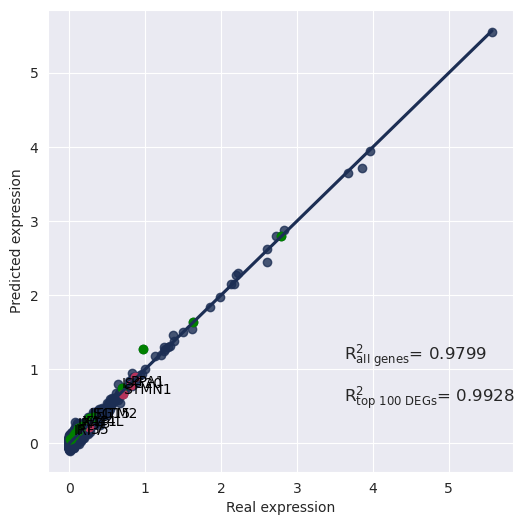

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


<Figure size 640x480 with 0 Axes>

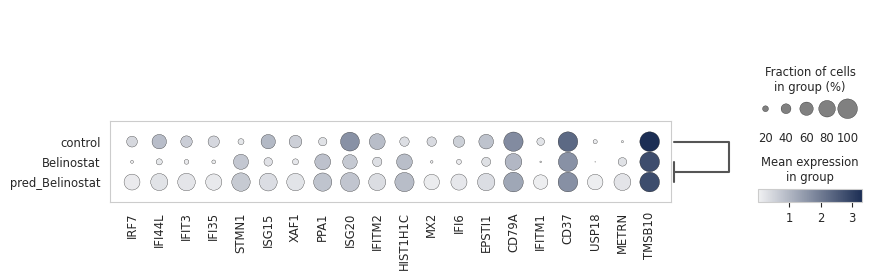

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


  0%|          | 0/9 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.7687375933497276
R2 top 50 DEGs:  0.8500009504121392
R2 all genes:  0.7580995664574098
R2 top 100 DEGs:  0.7552845232114405
2627


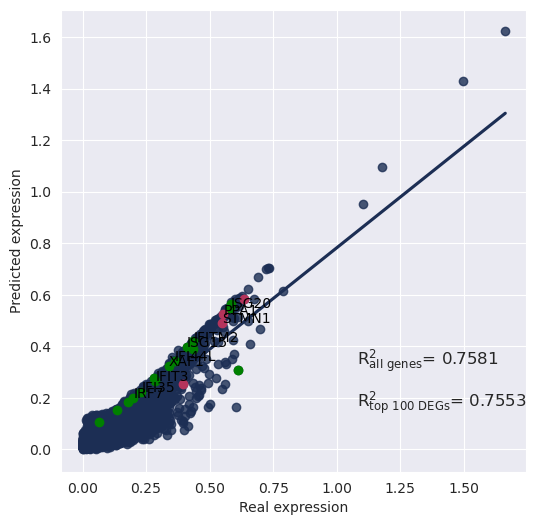

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


<Figure size 640x480 with 0 Axes>

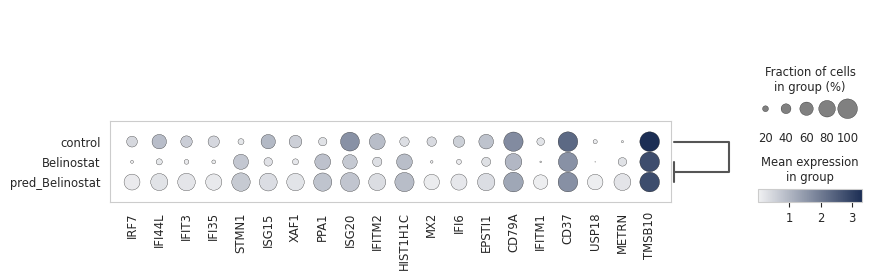

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  0%|          | 0/1 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.9963986479033692
R2 top 50 DEGs:  0.994154421109921
R2 all genes:  0.9808440341413147
R2 top 100 DEGs:  0.9949989321661972
2627


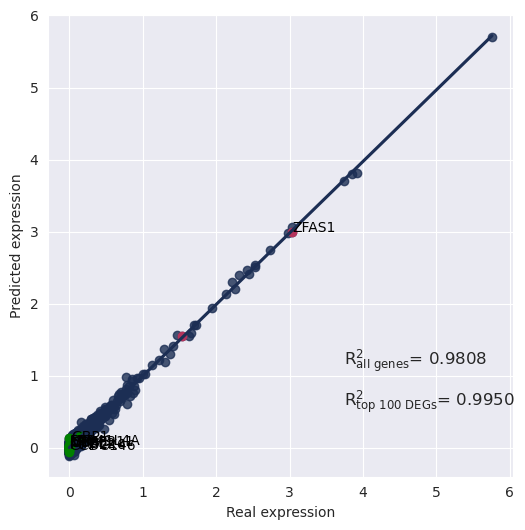

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


<Figure size 640x480 with 0 Axes>

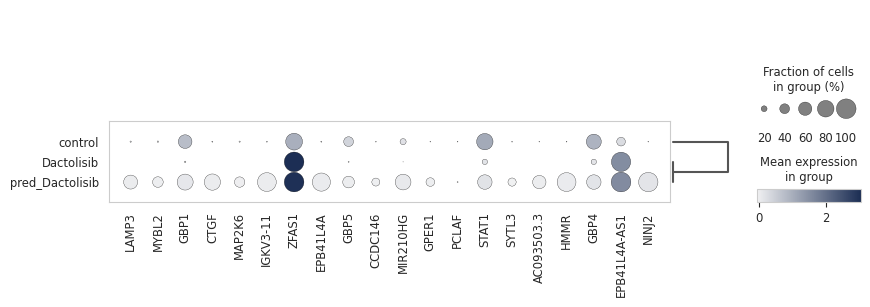

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


  0%|          | 0/1 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.9132449654705942
R2 top 50 DEGs:  0.924939396369486
R2 all genes:  0.7347553131066359
R2 top 100 DEGs:  0.9233330567836331
2627


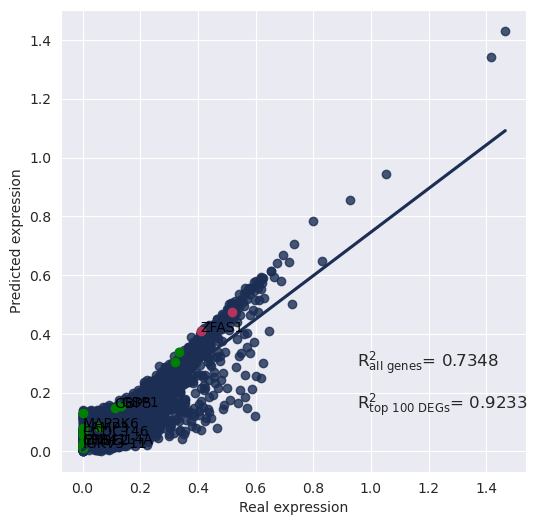

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


<Figure size 640x480 with 0 Axes>

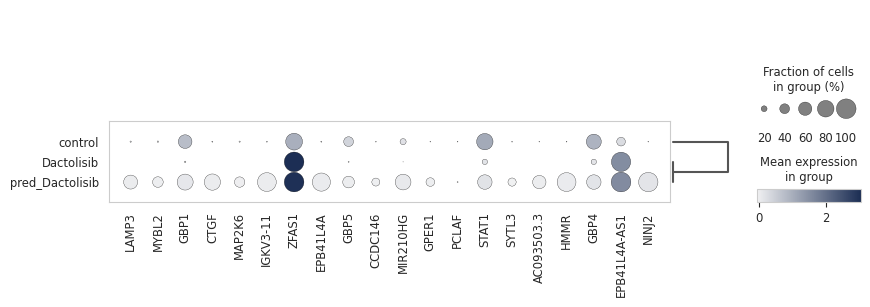

r2_all_avg 0.9803865163058767 r2_degs_avg 0.9939069746601554 r2_all_std 0.7464274397820229 r2_degs_std 0.8393087899975368


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
from importlib import reload
import utils
reload(utils)
from utils import *
import model
from importlib import reload
reload(model)
from model import *
import optuna
params = {'hidden_channels': 128, 'weight_decay': 1e-05, 'in_head': 1, 'learning_rate': -3, 'num_epochs': 100, 'batch_size': 512}
train_dataloader = DataLoader(cells_train+cells_valid, batch_size = params['batch_size'], shuffle=True)
torch.manual_seed(42) 
model = GNN(total_genes  = len(adata.var), num_perts = num_perts, act_fct = 'Sigmoid',
            hidden_channels = params['hidden_channels'], in_head = params['in_head']).to(device)
# model = train(model = model, num_epochs = params['num_epochs'], lr = 10**params['learning_rate'],
#                   weight_decay = params['weight_decay'],
#                   cell_type_network = cell_type_network, train_loader = train_dataloader)

# torch.save(model.state_dict(), save_path_models+"NeurIPS_model.pt")
model.load_state_dict(torch.load(save_path_models+"NeurIPS_model.pt"))
r2_all_avg = []
r2_degs_avg = []
r2_all_std = []
r2_degs_std = []
ood_loader_all = DataLoader(cells_ood, batch_size=len(cells_ood), shuffle=False)
ood_cells = np.array(next(iter(ood_loader_all)).cell_type)
cov_drugs = np.array(next(iter(ood_loader_all)).cov_drug)
pred_adata = []
for cov_drug in tq.tqdm(set(cov_drugs)):
    testing_drug = cov_drug.split('_')[1]
    ood_cell = cov_drug.split('_')[0]
    index_cell_type = np.where(cov_drugs == cov_drug)[0]
    data = [cells_ood[i] for i in index_cell_type]
    ood_loader_cell_type = DataLoader(data, batch_size=params['batch_size'], shuffle=False)
    if testing_drug != 'control':
        r2_all, r2_DEGs, DEGs_name, dot_adata =  Inference(cell_type_network, model, 
                   save_path_results+"NeurIPS_mean_"+testing_drug, ood_loader_cell_type, 
                   ood_cell, adata, testing_drug = testing_drug, 
                   degs_dict = adata.uns['rank_genes_groups_cov_DEGs'][ood_cell+'_'+testing_drug], mean_or_std = True, plot = True) 
        r2_all_avg.append(r2_all)
        r2_degs_avg.append(r2_DEGs)
        #---------------------------------------------------------------------------------------------------------
        r2_all, r2_DEGs, DEGs_name, dot_adata = Inference(cell_type_network, model, 
                   save_path_results+"NeurIPS_std_"+testing_drug, ood_loader_cell_type, 
                   ood_cell, adata, testing_drug = testing_drug, 
                   degs_dict = adata.uns['rank_genes_groups_cov_DEGs'][ood_cell+'_'+testing_drug], mean_or_std = False, plot = True)
        r2_all_std.append(r2_all)
        r2_degs_std.append(r2_DEGs)
        pred_adata.append(dot_adata)
pred_adata.append(adata[adata.obs.cov_drug == testing_cell+'_control', cell_type_network[testing_cell].pos.tolist()].copy())
print( 'r2_all_avg', np.mean(r2_all_avg),
        'r2_degs_avg', np.mean(r2_degs_avg),
        'r2_all_std', np.mean(r2_all_std),
        'r2_degs_std', np.mean(r2_degs_std) )

## Visualize the UMAP of Observed and Predicted Expression

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 13151 × 2627
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'condition', 'SMILES', 'dose_uM', 'timepoint_hr', 'control', 'cov_drug', 'condition_label', 'n_counts', 'SEACell', 'dose_value', 'split'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturb

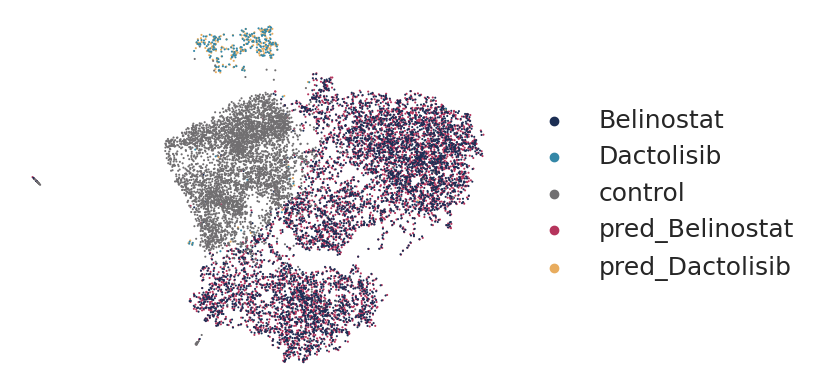

In [13]:
pred_adata_all = sc.concat(pred_adata, join='outer')
display(pred_adata_all)
pred_adata_all.obs.rename(columns={'condition': 'Treatment'}, inplace=True) 

sc.pp.neighbors(pred_adata_all)
sc.tl.umap(pred_adata_all) 
fig, ax = plt.subplots()
custom_colors = {'control': '#716F71', 'Belinostat': '#1C2E54', 'pred_Belinostat':'#B5345C', 'pred_Dactolisib': '#E8AC5E', 'Dactolisib': '#3487A7'}
sc.pl.umap(pred_adata_all, color='Treatment',  ax=ax, show=False, palette=custom_colors, frameon=False, legend_fontsize=18)
# Remove the box (spines) around the plot
ax.set_title('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(save_path_results+"UMAP_Pred_NeurIPS.pdf", bbox_inches='tight')
plt.show()

In [14]:
#pred_adata_all.write('cell_type_graphs_WS/training/Neurips_pred.h5ad')

In [15]:
# custom_colors = {'control': '#716F71', 'Belinostat': '#1C2E54', 'pred_Belinostat':'#B5345C'}
# Belinostat = pred_adata_all[(pred_adata_all.obs.Treatment == 'Belinostat') | (pred_adata_all.obs.Treatment == 'pred_Belinostat') | (pred_adata_all.obs.Treatment == 'control')].copy()
# Belinostat.X[Belinostat.X < 0.0] = 0.0
# sc.pl.violin(Belinostat, keys=['TMSB10'], groupby='Treatment', order = custom_colors, save = 'Belinostat_TMSB10')

In [16]:
#sc.pl.violin(Belinostat, keys=['ISG20'], groupby='Treatment', order = custom_colors, save = 'Belinostat_ISG20')

In [17]:
# custom_colors = {'control': '#716F71', 'pred_Dactolisib': '#E8AC5E', 'Dactolisib': '#3487A7'}
# Dactolisib = pred_adata_all[(pred_adata_all.obs.Treatment == 'Dactolisib') | (pred_adata_all.obs.Treatment == 'pred_Dactolisib') | (pred_adata_all.obs.Treatment == 'control')].copy()
# Dactolisib.X[Dactolisib.X < 0.0] = 0.0
# sc.pl.violin(Dactolisib, keys=['ZFAS1'], groupby='Treatment', order = custom_colors, save = 'Dactolisib_ZFAS1')

In [18]:
# sc.pl.violin(Dactolisib, keys=['EPB41L4A-AS1'], groupby='Treatment', order = custom_colors, save = 'Dactolisib_EPB41L4A-AS1')